In [108]:
import csv
import math

import requests
import pandas as pd
import sqlite3 as lite
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from bs4 import BeautifulSoup

## Download and process URL into a Dataframe with school life data

In [109]:
# Download and select wanted data from soup 
r = requests.get("http://web.archive.org/web/20110514112442/http://unstats.un.org/unsd/demographic/products/socind/education.htm")
soup = BeautifulSoup(r.content)
data = soup('table')[6].find_all('tr', 'tcont')
data = data[:-6]

# Iterate data to populate dictionary of tuples
records = [('Country', 'Year', 'Total', 'Men', 'Women')]
for subdata in data:
    row = subdata.find_all('td')
    country = str(row[0].get_text())
    year = int(row[1].get_text())
    total = int(row[4].get_text())
    men = int(row[7].get_text())
    women = int(row[10].get_text())
    record = (country, year, total, men, women)
    records.append(record)

# Create dataframe
school_life = pd.DataFrame(records[1:], columns=records[0])

# Show result
school_life.head(3)

,Country,Year,Total,Men,Women
0,Afghanistan,2004,8,11,5
1,Albania,2004,11,11,11
2,Algeria,2005,13,13,13


## Download and store gdp info in SQLITE Database

In [110]:
# Create database
con = lite.connect('education.db')
cur = con.cursor()

# Create and populate table gdp
with con:
	cur.execute('DROP TABLE IF EXISTS gdp')
	cur.execute('CREATE TABLE gdp (country_name REAL, _1999 INT, _2000 INT, _2001 INT, _2002 INT, _2003 INT, _2004 INT, _2005 INT, _2006 INT, _2007 INT, _2008 INT, _2009 INT, _2010 INT);')

with open('/Users/Stephanie/desktop/thinkful/projects/U3L3-scrape-data/world_bank_data/GDP.csv', 'rU') as inputFile:
    next(inputFile) # skip the first four lines
    next(inputFile)
    next(inputFile)
    next(inputFile)
    inputReader = csv.reader(inputFile)
    header = next(inputFile)
    for line in inputReader:
        with con:
            cur.execute('INSERT INTO gdp (country_name, _1999, _2000, _2001, _2002, _2003, _2004, _2005, _2006, _2007, _2008, _2009, _2010) VALUES ("' + line[0] + '","' + '","'.join(line[43:55]) + '");')

## Retrieve gdp table and merge with school life in one dataframe

In [111]:
with con:
	cur = con.cursor()
	cur.execute('SELECT * FROM gdp')
	rows = cur.fetchall()
	cols = [desc[0] for desc in cur.description]
	gdp = pd.DataFrame(rows, columns=cols)

con.close()

# Merge
merged = pd.merge(school_life, gdp, left_on='Country', right_on='country_name', how='inner')

merged.head(3)

,Country,Year,Total,Men,Women,country_name,_1999,_2000,_2001,_2002,_2003,_2004,_2005,_2006,_2007,_2008,_2009,_2010
0,Afghanistan,2004,8,11,5,Afghanistan,,,2.46167e+09,4.12882e+09,4.58365e+09,5.28546e+09,6.27508e+09,7.0576e+09,9.84384e+09,1.01905e+10,1.24869e+10,1.59368e+10
1,Albania,2004,11,11,11,Albania,3.41476e+09,3.63204e+09,4.06076e+09,4.43508e+09,5.74695e+09,7.31487e+09,8.15855e+09,8.99264e+09,1.0701e+10,1.28814e+10,1.20442e+10,1.1927e+10
2,Algeria,2005,13,13,13,Algeria,4.86406e+10,5.47901e+10,5.47447e+10,5.67603e+10,6.78638e+10,8.5325e+10,1.03198e+11,1.17027e+11,1.34977e+11,1.71001e+11,1.37211e+11,1.61207e+11


## Insert GDP of year of analysis in GDP_year

In [112]:
year_needed = merged['Year'].tolist()
formated_year_needed = pd.Series(['_' + str(row) for row in year_needed])
GDP = merged.lookup(formated_year_needed.index, formated_year_needed.values)

merged['GDP_year'] = GDP

## Clean data and check correlation

## Conclusions

There's a moderate positive correlation between number of years on school and GDP, however other variables must have an important impact as well in the school life.

In the cells above, we can see that as the GDP increases, so does the years of the education (but with a really high variance), although the linear regression doesn't have a high R2. Again, we see that other variables must have an important influence as well

In [113]:
clean_merged = merged[['Country', 'Total', 'Men', 'Women', 'Year', 'GDP_year']]
clean_merged = clean_merged[clean_merged.GDP_year != '']        # clean empty rows

# Log transform of GDP
clean_merged['log_GDP_year'] = [math.log(row) for row in clean_merged['GDP_year']]

# Show correlation
print(clean_merged[['Total', 'log_GDP_year']].corr())

                Total  log_GDP_year
Total         1.00000       0.47905
log_GDP_year  0.47905       1.00000


In [114]:
X = sm.add_constant(clean_merged['log_GDP_year'])
model = sm.OLS(clean_merged['Total'], X)
f = model.fit()
f.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Total   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     20.85
Date:                Wed, 25 Jan 2017   Prob (F-statistic):           2.07e-05
Time:                        22:45:09   Log-Likelihood:                -174.48
No. Observations:                  72   AIC:                             353.0
Df Residuals:                      70   BIC:                             357.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
const           -2.7741      3.331     -0.833      0.408        -9.417     3.869
log_GDP_year     0.6343      0.139      4.566      0.000         0.357     0.911
==============================================================================
Omnibus:                        0.310   Durbin-Watson:                   2.235
Prob(Omnibus):                  0.857   Jarque-Bera (JB):                0.248
Skew:                           0.138   Prob(JB):                        0.884
Kurtosis:                       2.919   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

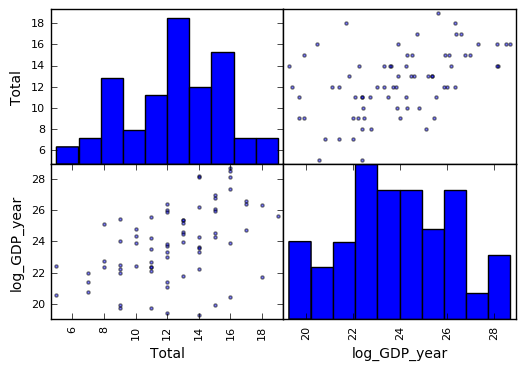

In [115]:
pd.scatter_matrix(clean_merged[['Total', 'log_GDP_year']], diagonal='hist')
plt.show()